In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def linear_equation(m, x, b):
    return (m*x) + b

def find_resistance(current_data, voltage_data):
    # R = V/I
    popt, pcov = curve_fit(linear_equation, current_data, voltage_data)
    resistance, intercept = popt
    resistance_sigma, intercept_sigma = np.sqrt(np.diag(pcov))
    return resistance, resistance_sigma

def load_and_plot(no_magnet, magnet, B, R):
    no_magnet_run = pd.read_csv(f'{no_magnet}', skiprows=8, index_col=0)
    no_magnet_current = no_magnet_run.iloc[:,13]
    no_magnet_volts = no_magnet_run.iloc[:,0]
    plt.plot(no_magnet_current, no_magnet_volts, color='blue', label='No Magnet')

    magnet_run = pd.read_csv(f'{magnet}', skiprows=8, index_col=0)
    magnet_current = magnet_run.iloc[:,13]
    magnet_volts = magnet_run.iloc[:,0]
    plt.plot(magnet_current, magnet_volts, color='red', label='Magnetized')

    plt.xlabel('Current (A)')
    plt.ylabel('Volts')
    plt.legend(title=f"Measured across {B} & {R}")
    plt.show()

    resistance, resistance_sigma = find_resistance(no_magnet_current, no_magnet_volts)
    print(f'Resistance without magnet found as {resistance:.3f} ohms +/- {resistance_sigma:.3f} ohms')

    hall_resistance, hall_resistance_sigma = find_resistance(magnet_current, magnet_volts)
    print(f'Hall resistance found as {hall_resistance:.3f} ohms +/- {hall_resistance_sigma:.3f} ohms')

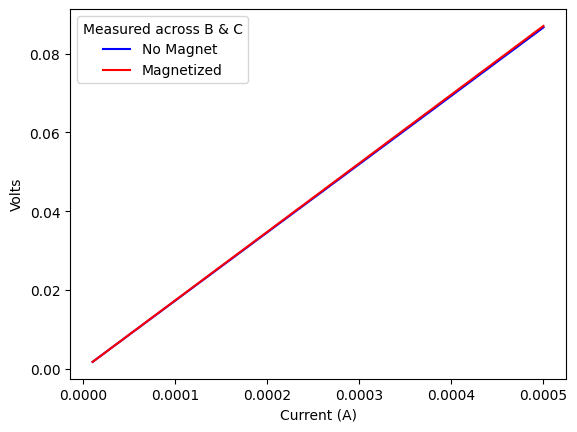

Resistance without magnet found as 173.281 ohms +/- 0.010 ohms
Hall resistance found as 174.069 ohms +/- 0.012 ohms


In [116]:
load_and_plot('Data/BbRcRUN1.csv', 'Data/BbRcRUN12.csv', 'B', 'C')

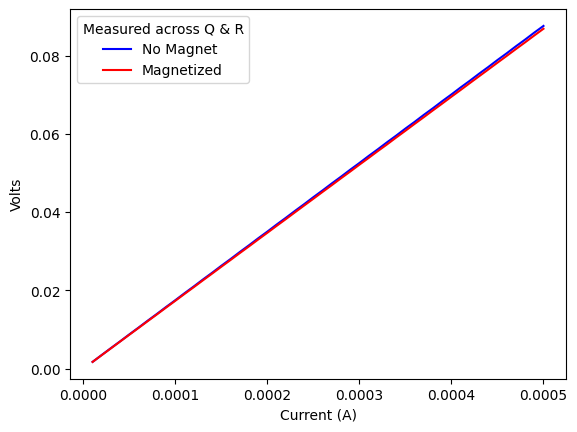

Resistance without magnet found as 175.232 ohms +/- 0.018 ohms
Hall resistance found as 173.772 ohms +/- 0.008 ohms


In [117]:
load_and_plot('Data/BqRrRUN2.csv', 'Data/BqRrRUN11.csv', 'Q', 'R')

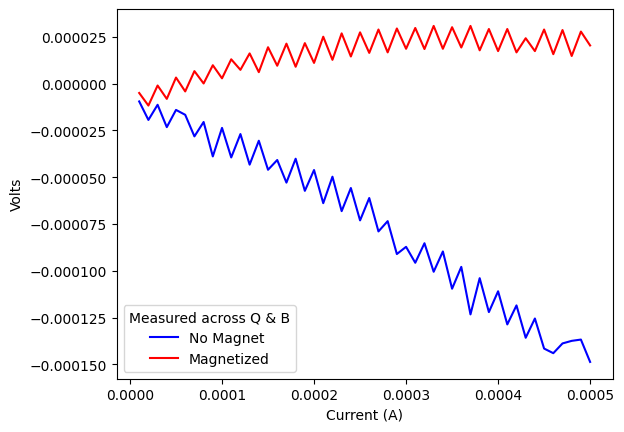

Resistance without magnet found as -0.290 ohms +/- 0.008 ohms
Hall resistance found as 0.056 ohms +/- 0.007 ohms


In [118]:
load_and_plot('Data/BqRbRUN3.csv', 'Data/BqRbRUN10.csv', 'Q', 'B')

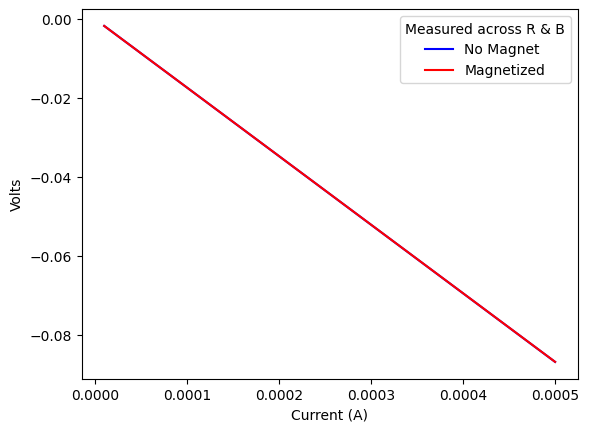

Resistance without magnet found as -173.873 ohms +/- 0.003 ohms
Hall resistance found as -173.842 ohms +/- 0.004 ohms


In [119]:
load_and_plot('Data/BrRbRUN4.csv', 'Data/BrRbRUN9.csv', 'R', 'B')

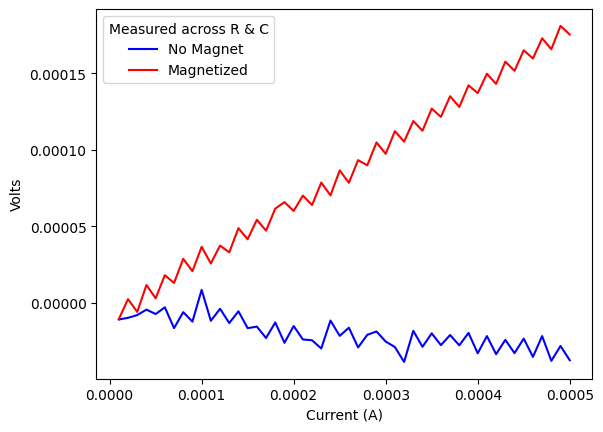

Resistance without magnet found as -0.056 ohms +/- 0.006 ohms
Hall resistance found as 0.378 ohms +/- 0.006 ohms


In [122]:
load_and_plot('Data/BrRcRUN5.csv', 'Data/BrRcRUN8.csv', 'R', 'C')

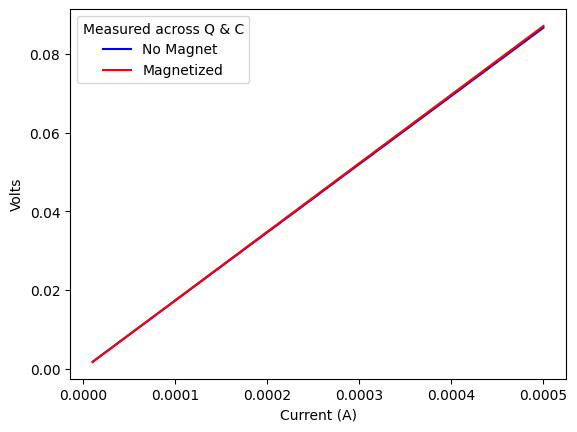

Resistance without magnet found as 173.370 ohms +/- 0.013 ohms
Hall resistance found as 174.273 ohms +/- 0.012 ohms


In [121]:
load_and_plot('Data/BqRcRUN6.csv', 'Data/BqRcRUN7.csv', 'Q', 'C')